<a href="https://colab.research.google.com/github/Jakoco/UnderLearning/blob/main/PyTorch_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network classification with PyTorch
Claddification is a problem of prediction whether something is one thing or another
(there can be multiple things as the option)

## 1.Make classification data and get it ready

In [1]:
import sklearn # A machine learning library

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
x,y = make_circles(n_samples,noise=0.03,random_state=42)

In [3]:
len(x),len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of x:\n{x[:5]}")
print(f"First 5 samples of y:\n{y[:5]}")

First 5 samples of x:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
[1 1 1 1 0]


In [5]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"x1":x[:,0],"x2":x[:,1],"label":y})
circles.head(10)

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


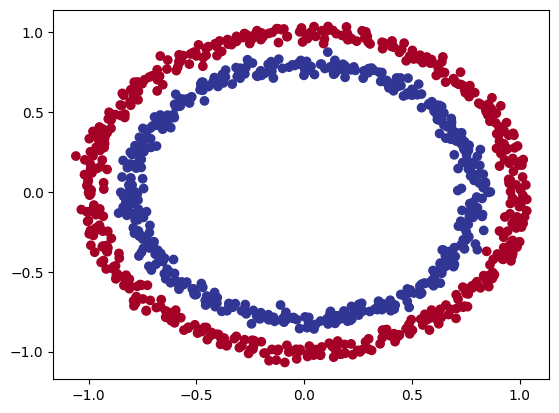

In [6]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=x[:,0],y=x[:,1],c=y,cmap=plt.cm.RdYlBu);

Note: The data Jakoco is working with is referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [7]:
x.shape,y.shape

((1000, 2), (1000,))

In [8]:
# View the first example of features and labels
x_sample = x[0]
y_sample = y[0]

### 1.2 Turn data into tensors and create train and test splits

In [9]:
import torch
torch.__version__

'2.0.1+cu118'

In [10]:
type(x),x.dtype

(numpy.ndarray, dtype('float64'))

In [11]:
# Turn data into tensor
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

x[:5],y[:5]                             

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
type(x),x.dtype,y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [13]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,
                          y,
                          test_size=0.2, # 20% of data will be test and 80% OF DATA WILL BE TRAIN
                          random_state=42)

In [14]:
len(x_train),len(x_test),len(y_train),len(y_test),n_samples

(800, 200, 800, 200, 1000)

## 2.Building a model

Building a model to classify blue and red dots.

So,:
1. Construct a model(by subclassing nn.Model)
2. Define a loss function and optimizer
3. Creat a training and test loop

In [15]:
# import PyTorch and nn
import torch
from torch import nn

### 2.1 create a model

1. Subclasses 'nn.Model' (almost all models in PyTorch subclass nn)
2. Create 2'NN.Linear()' layers that are capable of handing the shapes of the data
3. Defines a forward() method that outline the forward pass (or forward computataion) of the model
4. Lnstatiate an instance of the model class andd send it to the target device

In [16]:
x_train.shape,y_train[0]

(torch.Size([800, 2]), tensor(1.))

In [17]:
# 1. Construct a model
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handing the shapes of the data
    self.layer_1 = nn.Linear(in_features=2,out_features=5)# takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5,out_features=1)# takes in 5 featrures from previous layer and outputs a single feature(same shape as y)
  # 3. Define a forward() method that outlines the forward pass
  def forward(self,x):
    return self.layer_2(self.layer_1(x))# x -> layer_1 -> layer_2 -> output

# 4. INstantiate an instance of the model class and send it to the target device
model_0 = CircleModelV0()
# try: model_0 = CircleModelV0().to(device) if available
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
# Replicate the model above using nn.Sequentital()
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0316,  0.6368],
                      [ 0.0954, -0.6648],
                      [ 0.5144, -0.3663],
                      [-0.3058, -0.5439],
                      [-0.1685,  0.6412]])),
             ('0.bias', tensor([-0.3140, -0.3047, -0.2193, -0.0688,  0.1925])),
             ('1.weight',
              tensor([[-0.2203,  0.1010,  0.2861, -0.3906,  0.0515]])),
             ('1.bias', tensor([0.1543]))])

In [20]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(x_test)
print(f"\nFrist 10 perdictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")


Frist 10 perdictions:
tensor([[ 0.0182],
        [ 0.1069],
        [-0.0052],
        [ 0.0240],
        [ 0.3269],
        [ 0.3784],
        [ 0.3650],
        [ 0.4295],
        [-0.0191],
        [ 0.1165]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [21]:
x_test[:10],y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.2 Setup loss function and optimizer

(?)Choose of loss function or optimizer:

For regression -> MAE or MSE (mean absolute error or mean squared error)

For classification -> BCE or CCE (binary cross enyropy or categorical cross entropy)(cross entropy)

In [22]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # i.e., sigmoid activation function built_in

optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [23]:
# Calculate accuracy - out of 100 examples, what percentage does the model get right
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()# Here once to be a gorgeous bug, only Jakoco and God can tell it.(y_test -> y_pred)
  # Now only God can tell it. 
  acc = (correct/len(y_pred))*100
  return acc

## 3.Train model

To train a model, thou should build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction lables

The outputs of this model are going to be raw **logits**

By passing these **logits** to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification), they will be convert into **prediction probabilities**, and then into **prediction labels**.

*Originally, logit is the inverse function of sigmoid. But in deep learning, it is the final output of the fully connected layer*.


In [24]:
# use the sigmoid activation on the model logits to turn them into prediction probabilities
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(x_test)
y_pred_probs = torch.sigmoid(y_logits)

For prediction probability values, we need to perform a range_style rounding on them:

* y_pred_probs >= 0.5, y=1(class 1)
* y_pred_probs < 0.5, y=0(class 2)

In [25]:
# Find the prediction lables
y_preds = torch.round(y_pred_probs)

# In full(logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(x_test)))

# Check for equality
print(torch.eq(y_preds.squeeze(),y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

tensor([1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0.,
        0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        0., 1.])

In [26]:
# Double check
y_test == y_preds.squeeze()

tensor([ True, False, False, False,  True,  True, False, False, False, False,
         True,  True, False,  True,  True,  True,  True,  True, False,  True,
        False, False, False,  True, False, False, False, False,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False,  True, False,  True,  True, False, False,  True,  True,
        False,  True, False, False,  True, False,  True,  True, False,  True,
         True, False,  True,  True,  True,  True,  True, False, False, False,
         True, False,  True, False,  True,  True,  True, False,  True,  True,
         True,  True, False,  True, False,  True, False, False, False, False,
        False,  True,  True,  True,  True,  True,  True, False,  True,  True,
        False,  True,  True,  True,  True, False,  True, False, False,  True,
         True, False, False,  True,  True, False,  True,  True,  True, False,
        False, False, False, False,  True, False,  True,  True, 

### 3.2 Building a training and test loop

In [27]:
# Set the number of epochs
epochs = 100

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing 
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/accuracy
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

    # Print out!!!
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc:{acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 0.70047, Acc:53.12% | Test loss: 0.70153, Test acc: 55.00%
Epoch: 10 | Loss: 0.69813, Acc:51.88% | Test loss: 0.69984, Test acc: 53.00%
Epoch: 20 | Loss: 0.69679, Acc:51.50% | Test loss: 0.69897, Test acc: 51.00%
Epoch: 30 | Loss: 0.69596, Acc:51.50% | Test loss: 0.69850, Test acc: 51.00%
Epoch: 40 | Loss: 0.69541, Acc:51.00% | Test loss: 0.69822, Test acc: 51.00%
Epoch: 50 | Loss: 0.69503, Acc:51.00% | Test loss: 0.69804, Test acc: 51.00%
Epoch: 60 | Loss: 0.69474, Acc:50.88% | Test loss: 0.69790, Test acc: 49.50%
Epoch: 70 | Loss: 0.69451, Acc:51.00% | Test loss: 0.69778, Test acc: 49.00%
Epoch: 80 | Loss: 0.69433, Acc:50.75% | Test loss: 0.69767, Test acc: 49.00%
Epoch: 90 | Loss: 0.69418, Acc:51.25% | Test loss: 0.69756, Test acc: 48.50%


Jakoco think it is something better than nothing

## 4.Make predictions and evaluation the model

From the metrics above, it looks like the model is not learning anything.

In [28]:
### Reference from (Mrdbourke,https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py)

"""
A series of helper functions used throughout the course.
If a function gets defined once and could be used over and over, it'll go in here.
"""
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn

import os
import zipfile

from pathlib import Path

import requests

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
    dir_path (str): target directory
    Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.
    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.
    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.
    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.
    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.
    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


# Pred and plot image function from notebook 04
# See creation: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function
from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.
    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".
    
    Returns:
        Matplotlib plot of target image and model prediction as title.
    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.
    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.
    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

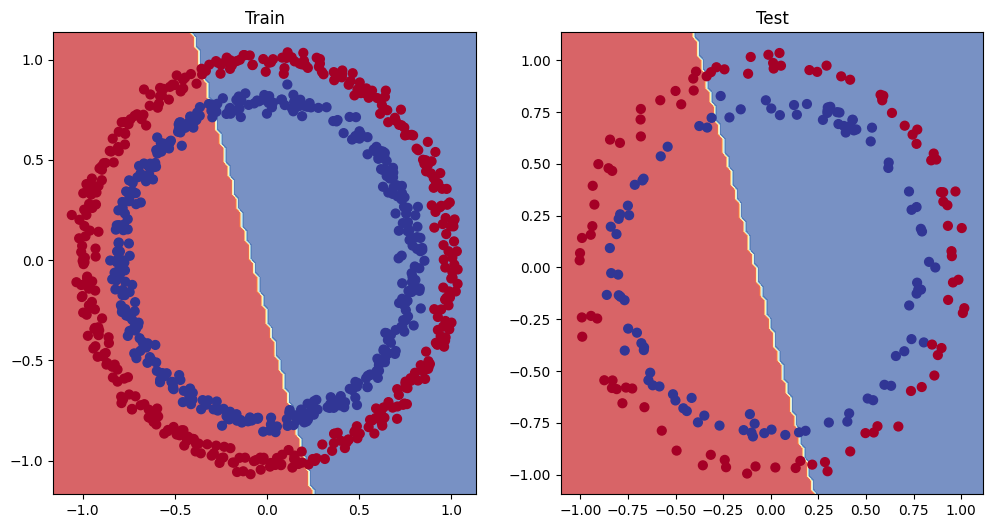

In [29]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,x_train,y_train) 
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,x_test,y_test)

## 5.Improving a model

* Add more layer - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation function
* Changeing the learning rate

These options all from a model's perspective rather than data.

And because these options are all values Jakoco(as a future machine learning engineer and data scientist and a present big devil) can change, they are referrd as **hyperparameters**

*A hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are learned. The same kind of machine learning model can require different constraints, weights or learning rates to generalize different data patterns.*

Jakoco will try improve his model by:
* Adding more hidden units: 5 -> 10
* Lncrease the number of layers: 2 -> 3
* Lincease the number of epochs: 100 -> 1000



In [30]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
  
  def forward(self,x):
    z = self.layer_1(x)
    z = self.layer_2(z)
    z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))# This way of writing operations leverages speed ups where possible behind the scene

model_1 = CircleModelV1()
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0019,  0.6269],
                      [ 0.0766, -0.6594],
                      [ 0.4662, -0.3523],
                      [-0.2315, -0.5647],
                      [-0.1831,  0.6448]])),
             ('0.bias', tensor([-0.2903, -0.3174, -0.2527, -0.0195,  0.1840])),
             ('1.weight',
              tensor([[-0.1444,  0.0882,  0.2009, -0.3623,  0.0965]])),
             ('1.bias', tensor([0.0255]))])

In [32]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.5930,  0.0722],
                      [ 0.5094, -0.1397],
                      [-0.1678,  0.2888],
                      [-0.2141, -0.3466],
                      [ 0.2495,  0.1663],
                      [ 0.2011,  0.4723],
                      [ 0.1838,  0.1375],
                      [-0.3817,  0.0112],
                      [ 0.6481, -0.3870],
                      [-0.1307, -0.6024]])),
             ('layer_1.bias',
              tensor([ 0.0075, -0.3854,  0.6630, -0.0559,  0.4003,  0.6617,  0.3283,  0.3966,
                      -0.0591,  0.3369])),
             ('layer_2.weight',
              tensor([[-0.2105,  0.2971,  0.3150,  0.2520, -0.0284,  0.0604,  0.2373, -0.1815,
                        0.2521, -0.2157],
                      [ 0.0073,  0.0155,  0.0733,  0.0279, -0.1278,  0.1515, -0.2103,  0.2087,
                        0.0931, -0.1663],
                      [ 0.0330, -0.0463, -0.0432, -0.1861,  0.0374, -0.0

Model_1 is much larger than model_0, but still, it is a very small model.

In [33]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create a optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.1)

In [34]:
# Train for longer
epochs = 1000

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))# logits -> prediction probabilities -> prediction lables

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing 
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/accuracy
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

    # Print something
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc:{acc:.2f}% | Test loss: {test_loss:.5f},Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69541, Acc:50.00% | Test loss: 0.69707,Test acc: 50.00
Epoch: 100 | Loss: 0.69305, Acc:50.75% | Test loss: 0.69503,Test acc: 45.50
Epoch: 200 | Loss: 0.69299, Acc:51.12% | Test loss: 0.69479,Test acc: 46.50
Epoch: 300 | Loss: 0.69298, Acc:50.88% | Test loss: 0.69471,Test acc: 46.50
Epoch: 400 | Loss: 0.69298, Acc:51.50% | Test loss: 0.69469,Test acc: 46.00
Epoch: 500 | Loss: 0.69298, Acc:51.50% | Test loss: 0.69468,Test acc: 45.00
Epoch: 600 | Loss: 0.69298, Acc:51.25% | Test loss: 0.69468,Test acc: 45.00
Epoch: 700 | Loss: 0.69298, Acc:51.12% | Test loss: 0.69468,Test acc: 45.50
Epoch: 800 | Loss: 0.69298, Acc:51.12% | Test loss: 0.69468,Test acc: 46.00
Epoch: 900 | Loss: 0.69298, Acc:51.00% | Test loss: 0.69468,Test acc: 46.00


Some Chinese slang

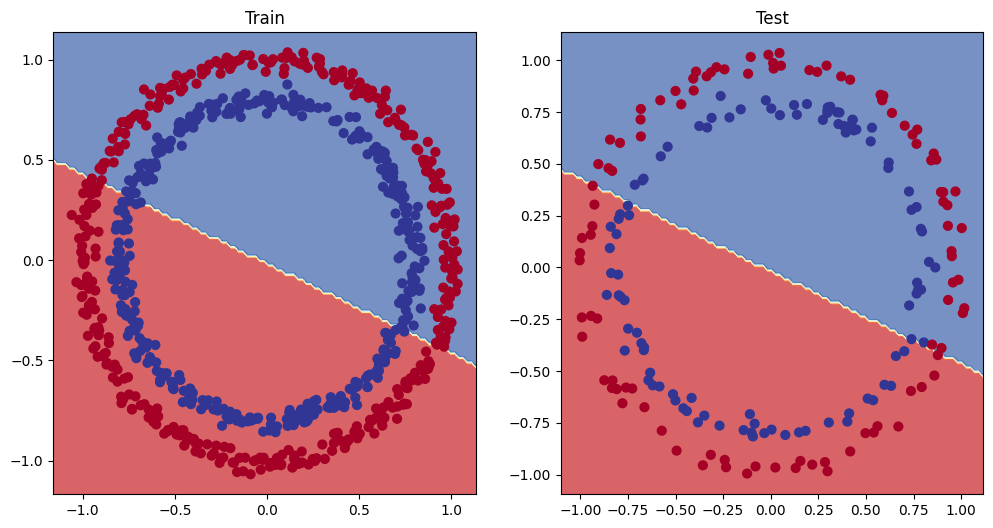

In [35]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,x_train,y_train) 
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,x_test,y_test)

### 5.1 preparing data to see if the model can fit a straight line

one way to troubleshoot to a larger problem is to test out a smaller problem.


In [36]:
# Create some data (same as notebook 1)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
Y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5],Y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [37]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression,Y_train_regression = X_regression[:train_split],Y_regression[:train_split]
X_test_regression,Y_test_regression = X_regression[train_split:],Y_regression[train_split:]

len(X_train_regression),len(X_test_regression),len(Y_train_regression),len(Y_test_regression)

(80, 20, 80, 20)

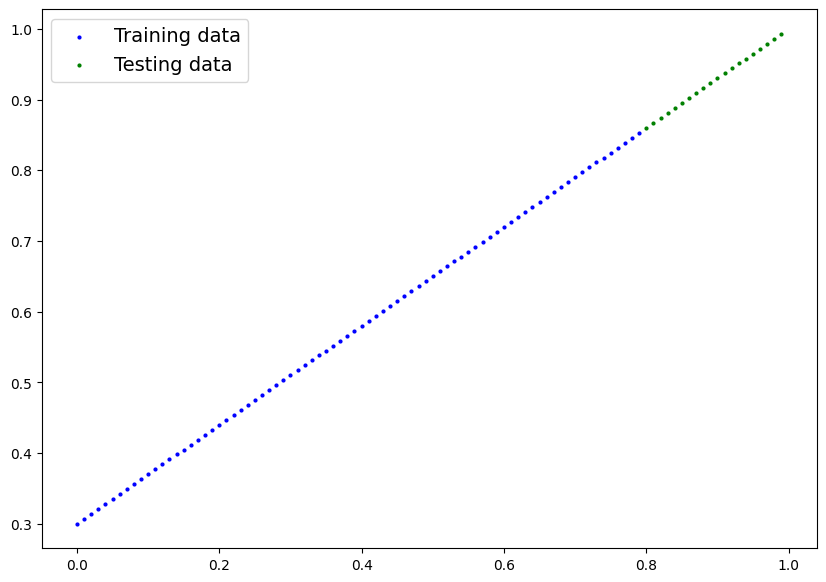

In [38]:
plot_predictions(train_data=X_train_regression,
        train_labels=Y_train_regression,
        test_data=X_test_regression,
        test_labels=Y_test_regression);

### 5.2 Adjusting model_1 to fit a straight line

In [39]:
# Same architecture as model_1 but nn.Sequential()

model_2 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [40]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),lr=0.01)


In [41]:
# Set the number of epochs
epochs = 1000

# Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred,Y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred,Y_test_regression)

  if epoch%100==0:
    print(f"Epoch:{epoch}| Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch:0| Loss: 0.73027 | Test loss: 0.98932
Epoch:100| Loss: 0.04280 | Test loss: 0.00209
Epoch:200| Loss: 0.04452 | Test loss: 0.00362
Epoch:300| Loss: 0.04176 | Test loss: 0.00311
Epoch:400| Loss: 0.03793 | Test loss: 0.00183
Epoch:500| Loss: 0.03602 | Test loss: 0.00196
Epoch:600| Loss: 0.03441 | Test loss: 0.00218
Epoch:700| Loss: 0.03305 | Test loss: 0.00252
Epoch:800| Loss: 0.03328 | Test loss: 0.00469
Epoch:900| Loss: 0.03089 | Test loss: 0.00366


## 6.The missing piece: non-linearity

### 6.1 Recreating non-linear data

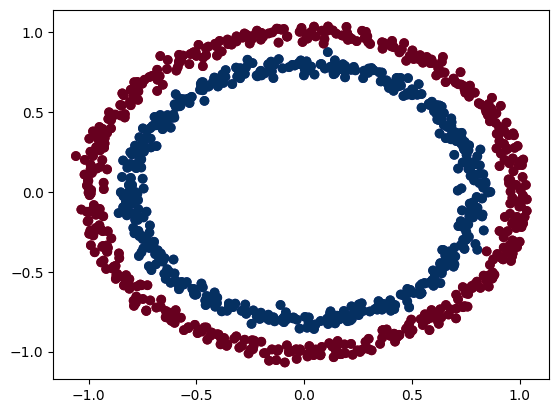

In [42]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
plt.scatter(x=x[:,0],y=x[:,1],c=y,cmap=plt.cm.RdYlBu);

n_samples = 1000

x,y = make_circles(n_samples,noise=0.03,random_state=42)

plt.scatter(x[:,0],x[:,1],c=y,cmap=plt.cm.RdBu);

In [43]:
# convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensor
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test setd
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

x_train[:5],y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## 6.2 Building a model with non-linearity
* Linear = straight linear
* Non-linear = non-straight lines

Artificial neural network are a large combination of linear and non-linear functions which are potentially able to find patterns data.

In [44]:
# Build a model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2()
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [45]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),lr=0.1)

### 6.3 Training a model with non_linearity

In [46]:
# Loop through data
epochs = 1000

for epoch in range(epochs):
  ### Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

  # Print something!
  if epoch % 100 == 0:
    print(f"Epoch:{epoch} | Loss:{loss:.4f}, Acc:{acc:.2f}% |Test Loss:{test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch:0 | Loss:0.6931, Acc:62.75% |Test Loss:0.6941, Test Acc: 58.00%
Epoch:100 | Loss:0.6893, Acc:57.75% |Test Loss:0.6892, Test Acc: 58.50%
Epoch:200 | Loss:0.6858, Acc:71.75% |Test Loss:0.6857, Test Acc: 77.00%
Epoch:300 | Loss:0.6810, Acc:70.75% |Test Loss:0.6820, Test Acc: 71.50%
Epoch:400 | Loss:0.6743, Acc:69.50% |Test Loss:0.6766, Test Acc: 67.50%
Epoch:500 | Loss:0.6643, Acc:69.12% |Test Loss:0.6688, Test Acc: 67.50%
Epoch:600 | Loss:0.6485, Acc:71.75% |Test Loss:0.6565, Test Acc: 69.00%
Epoch:700 | Loss:0.6221, Acc:78.88% |Test Loss:0.6343, Test Acc: 76.00%
Epoch:800 | Loss:0.5721, Acc:95.00% |Test Loss:0.5897, Test Acc: 93.00%
Epoch:900 | Loss:0.4824, Acc:99.25% |Test Loss:0.5100, Test Acc: 97.50%


Hah

### 6.4 Evaluating a model trained with non-linear activation functions

In [47]:
# Make prediction
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(x_test))).squeeze()
y_preds[:10],y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

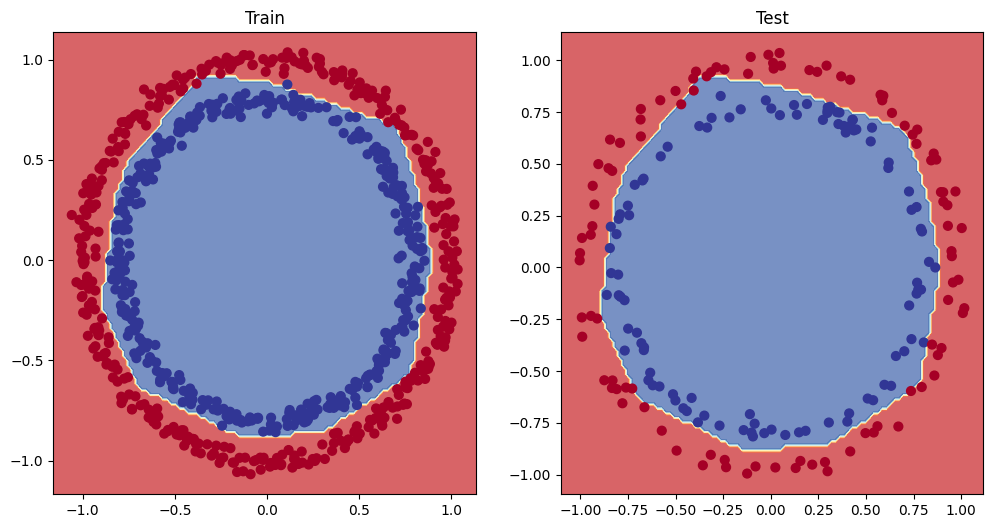

In [48]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,x_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,x_test,y_test)

## 7.Replicating non-linear activation function

Neural networks, rather than Jakoco telling the model what to learn, giving it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear & and non-linear function

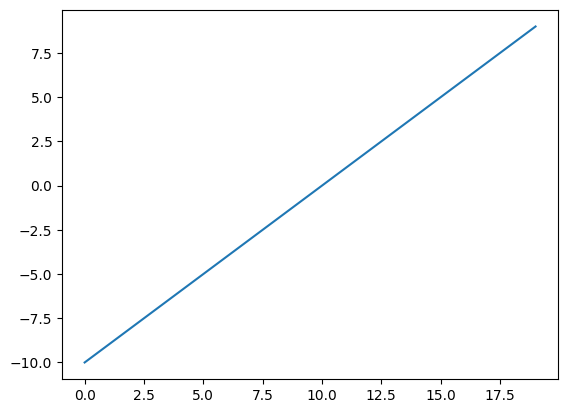

In [49]:
def relu(x:torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0),x)

# Visualize
A = torch.arange(-10,10,1,dtype=torch.float32)
plt.plot(A);

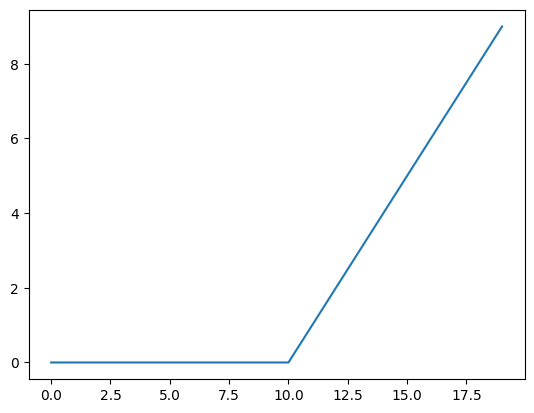

In [50]:
plt.plot(relu(A));

In [51]:
# Same for sigmoid
def sigmoid(x):
  return 1/(1+torch.exp(-x))

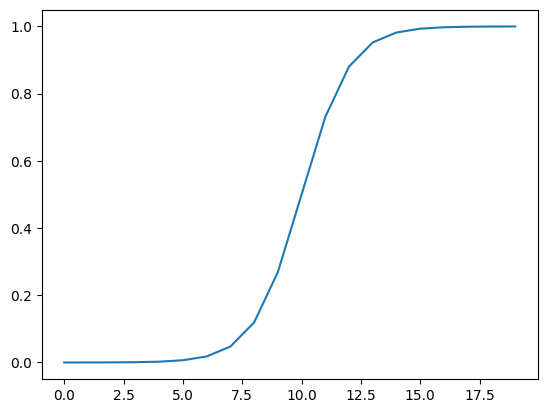

In [52]:
# Viualize
plt.plot(sigmoid(A));

## 8.Multi-class classification problem
* Binary classification = one thing or another
* Multi-class classification = more than one thing or another

### 8.1 Creating a toy multi-class dataset

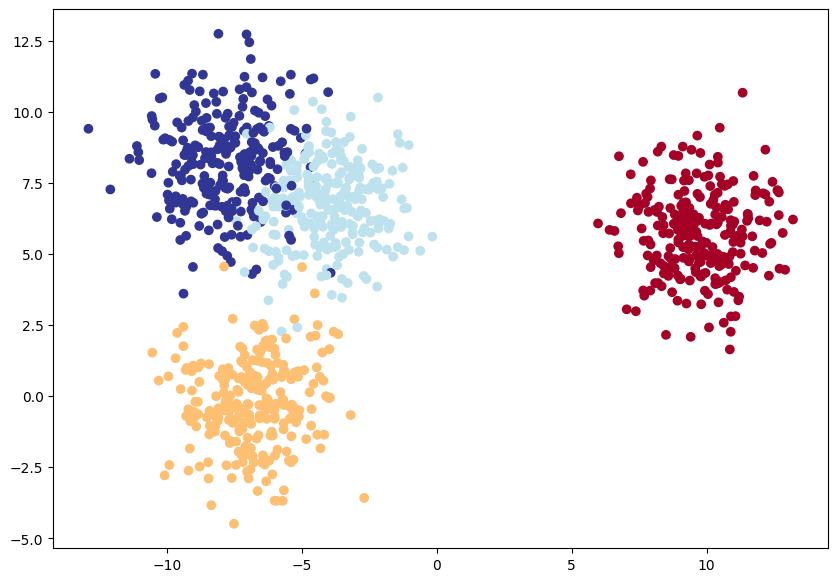

In [101]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi_class data
x_blob,y_blob = make_blobs(n_samples=1000,
              n_features=NUM_FEATURES,
              centers=NUM_CLASSES,
              cluster_std=1.5# give the clusters a little snake up
              )

# 2. Turn data into tensors
x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
x_blob_train, x_blob_test, y_blob_train, y_blob_test = train_test_split(x_blob,
                                      y_blob,
                                      test_size=0.2
                                      )

# 4. Plot data
plt.figure(figsize=(10,7))
plt.scatter(x_blob[:,0],x_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu);

### 8.2 Building a multi-class classification model

In [102]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__ (self,input_features,output_features,hidden_units=8):
    """
    Initializes multi-class classification model.

    Args:
     input_features (int): Number of input features to the model
     output_features (int): Number of outputs features (Number of output classes) 
     hidden_units (int): Number of hidden units between layers, default 8
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),# Though this simple have separated linerly, most of data that Jakoco deal with will require both linear and nonlinear layers. 
        nn.Linear(in_features=hidden_units, out_features=output_features),
        )
  def forward(self,x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2,
           output_features=4,
           hidden_units=8)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [103]:
x_blob_train.shape,y_blob_train[:5]

(torch.Size([800, 2]), tensor([2, 1, 1, 0, 1]))

### 8.3 Creats a loss function and an optimizer for a multi-class classification model

In [104]:
# Create a loss function
loss_fn = nn.CrossEntropyLoss()

# Create a optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
               lr=0.1)

### 8.4 Getting prediction probabilities 

In order to evaluate and train and test the model, we need to conver the model's outputs (logits) to perdiction probabilities and then to prediction labels.

Logits (raw oytput of the model) -> Pred probs (use 'torch.softmax') -> pred labels (take the argmax of the perdiction probabilities)



In [105]:
# Getting some raw output of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(x_blob_test)

y_logits[:10]  

tensor([[ 0.5118, -0.6611,  0.8075, -0.1359],
        [ 0.1193, -1.0814,  1.1447, -0.1712],
        [ 0.3388, -0.9480,  1.1691, -0.1385],
        [ 0.1791, -0.1786, -0.4822,  0.1487],
        [ 0.3123, -0.2465, -0.4692,  0.1250],
        [ 0.3093, -0.8733,  0.8092, -0.0715],
        [-0.5121, -1.7675, -1.8791,  0.1737],
        [ 0.0712, -0.1221, -0.5000,  0.1664],
        [-0.4406, -1.5977, -1.7377,  0.1788],
        [ 0.3233, -0.9263,  1.0393, -0.1133]])

In [106]:
y_blob_test[:10]
# y_blob_test only has 1 feature for each but y_logits has 4 associated with, this is because the output_features given in model_4 is 4.

tensor([2, 3, 3, 0, 0, 3, 1, 0, 1, 3])

In [107]:
# Convert the model's logtis output to predoction probabilities
y_pred_probs = torch.softmax(y_logits,dim=1)
print(y_logits[:3])
print(y_pred_probs[:5])

tensor([[ 0.5118, -0.6611,  0.8075, -0.1359],
        [ 0.1193, -1.0814,  1.1447, -0.1712],
        [ 0.3388, -0.9480,  1.1691, -0.1385]])
tensor([[0.3148, 0.0974, 0.4231, 0.1647],
        [0.2067, 0.0622, 0.5764, 0.1546],
        [0.2386, 0.0659, 0.5474, 0.1481],
        [0.3139, 0.2195, 0.1620, 0.3045],
        [0.3498, 0.2000, 0.1601, 0.2900]])


In [108]:
torch.sum(y_pred_probs[0]),torch.max(y_pred_probs[0]),torch.argmax(y_pred_probs[0])

(tensor(1.), tensor(0.4231), tensor(2))

In [109]:
# Convert the model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds

tensor([2, 2, 2, 0, 0, 2, 3, 3, 3, 2, 3, 0, 2, 2, 3, 3, 3, 2, 0, 0, 3, 3, 2, 0,
        2, 0, 3, 0, 2, 3, 3, 3, 3, 2, 3, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 3, 2, 3,
        0, 3, 2, 0, 3, 3, 0, 3, 0, 2, 0, 3, 3, 3, 0, 2, 3, 2, 2, 2, 2, 2, 3, 3,
        3, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 0, 2, 0, 2, 3, 2, 3, 2, 2, 0, 3, 2, 0,
        0, 3, 2, 2, 0, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 0, 3, 2, 3, 2, 2, 3, 3,
        3, 2, 2, 3, 2, 2, 3, 2, 0, 3, 3, 3, 2, 2, 2, 0, 2, 3, 2, 2, 0, 2, 2, 0,
        2, 0, 0, 0, 2, 3, 0, 0, 2, 2, 2, 2, 2, 3, 3, 2, 0, 0, 2, 3, 3, 2, 2, 2,
        3, 2, 3, 3, 0, 2, 3, 0, 2, 0, 2, 3, 0, 3, 0, 2, 3, 0, 3, 2, 3, 0, 2, 0,
        3, 2, 0, 0, 3, 2, 2, 2])

In [110]:
# I'm blind!
y_preds == y_blob_test

tensor([ True, False, False,  True,  True, False, False, False, False, False,
        False,  True, False, False, False, False, False,  True,  True,  True,
        False, False, False,  True,  True,  True, False,  True, False, False,
        False, False, False,  True, False,  True, False, False,  True,  True,
         True,  True,  True,  True,  True, False,  True, False,  True, False,
         True,  True, False, False,  True, False,  True, False,  True, False,
        False, False,  True, False, False, False, False, False,  True,  True,
        False, False, False,  True,  True, False, False, False, False, False,
        False, False, False,  True, False,  True, False, False, False, False,
         True,  True, False, False, False, False,  True, False,  True, False,
         True,  True, False, False, False, False, False, False,  True,  True,
        False, False,  True, False,  True, False,  True,  True, False, False,
        False, False, False, False, False, False, False, False, 

### 8.5 Creating a training loop and test loop for the model

In [111]:
# Set number of epochs
epochs = 100

# Loop through data
for epochs in range(epochs):
  ### Training
  model_4.train()

  y_logits = model_4(x_blob_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss = loss_fn(y_logits,y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(x_blob_test)
    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits,y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,y_pred=test_preds)
  # Print out 
  if epochs % 10 == 0:
    print(f"Epoch: {epochs} | Loss: {loss:.4f}, Acc {acc:.2f} | Test loss: {test_loss:.4f}|, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.5428, Acc 40.75 | Test loss: 1.0755|, Test acc: 51.50%
Epoch: 10 | Loss: 0.4373, Acc 80.38 | Test loss: 0.3750|, Test acc: 84.50%
Epoch: 20 | Loss: 0.4940, Acc 74.38 | Test loss: 0.4503|, Test acc: 78.50%
Epoch: 30 | Loss: 0.3691, Acc 81.88 | Test loss: 0.3252|, Test acc: 81.50%
Epoch: 40 | Loss: 0.3421, Acc 83.25 | Test loss: 0.3023|, Test acc: 84.00%
Epoch: 50 | Loss: 0.3208, Acc 84.38 | Test loss: 0.2866|, Test acc: 87.00%
Epoch: 60 | Loss: 0.3028, Acc 86.50 | Test loss: 0.2723|, Test acc: 88.50%
Epoch: 70 | Loss: 0.2901, Acc 87.00 | Test loss: 0.2639|, Test acc: 89.00%
Epoch: 80 | Loss: 0.2793, Acc 87.88 | Test loss: 0.2562|, Test acc: 88.50%
Epoch: 90 | Loss: 0.2705, Acc 88.38 | Test loss: 0.2497|, Test acc: 88.50%


### 8.6 Making and evaluating prediction with a PyTorch mlti-class model

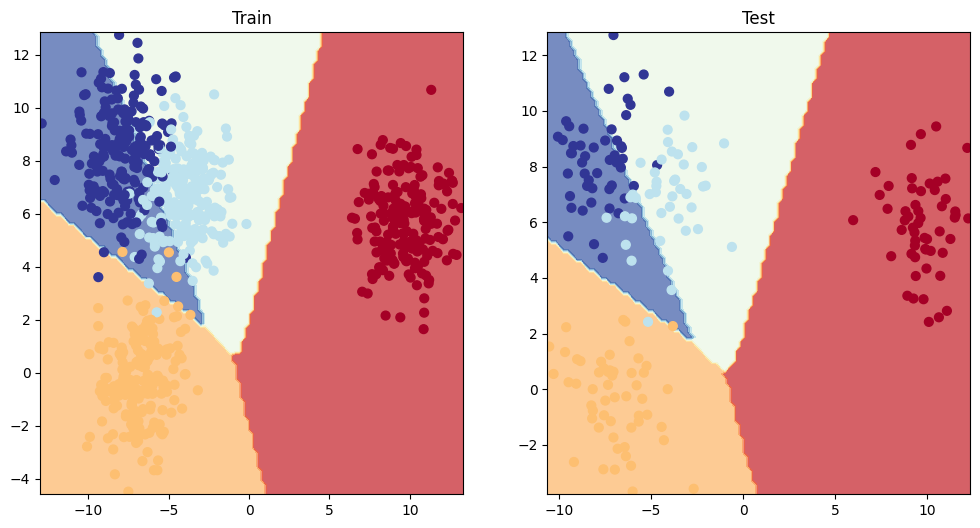

In [112]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,x_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,x_blob_test,y_blob_test)